# PyTorch CNN Digits Classifier
**Dataset:** MNIST

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

from torch import nn
from torch import optim
import torch.nn.functional as F

from torch.optim import lr_scheduler


# to initialize the weights of the Net
import torch.nn.init as I
import datetime


In [2]:
create_data = False
train_network = True

batch_size = 64
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda'
device

'cpu'

In [0]:
def print_validation(train_dataset_len, batch_size, epoch, epochs, step, running_loss, print_every, test_loss, len_val, accuracy):
    now = datetime.datetime.now()
    print("Epoch: {}/{}... ".format(epoch + 1, epochs),
          "Step: ({}/{}) ".format(step, int(train_dataset_len/batch_size)),
          "Loss: {:.3f}".format(running_loss/print_every),
          "Val Loss: {:.3f}".format(test_loss/len_val),
          "Val Acc: {:.3f}".format(accuracy/len_val),
          now)


def print_get_prediction(train_dataset_len, batch_size, step, old_now):
    now = datetime.datetime.now()
    print("Step: ({}/{}) ".format(step, int(train_dataset_len/batch_size)),
          now, "--> (remaining time: {0})".format((now - old_now) * (int(train_dataset_len/batch_size) - step))
          )
    return now


**Download _MNIST_ dataset**  
I will be using batches of 64

In [5]:
# Define a transform to normalize the data
 transformations = transforms.Compose([
    transforms.Resize(28),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])
                             
# Download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transformations)
train_loader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transformations)
test_loader = torch.utils.data.DataLoader(testset, batch_size= batch_size, shuffle=True)


Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw
Processing...
Done!


In [22]:
print(len(trainset))

60000


In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [0]:
def print_sample_digit(index):
    print(str.format('Label: {}',labels[index]))
    plt.figure(num=None, figsize=(1, 1), dpi=56, facecolor='w', edgecolor='k')
    plt.imshow(images[index].numpy().squeeze(), cmap='Greys_r');

Label: 9


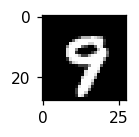

In [8]:
print_sample_digit(0)

Label: 7


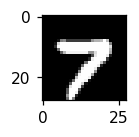

In [9]:
print_sample_digit(1)

### Define the model

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()        
        #(28x28x1)
        self.conv1 = nn.Conv2d(1, 32, 4)
        #(25x25x32)
        self.pool1 = nn.MaxPool2d(2)
        #(12x12x32)
        self.dropout1 = nn.Dropout(p=0.4)
                
        #(12x12x32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        #(10x10x64)
        self.pool2 = nn.MaxPool2d(2)
        #(5x5x64)
        #self.dropout2 = nn.Dropout(p=0.2)
                
        #(5x5x64)
        self.conv3 = nn.Conv2d(64, 128, 2)
        #(4x4x128)
        self.pool3 = nn.MaxPool2d(2)
        #(2x2x128)
        #self.dropout3 = nn.Dropout(p=0.3)
                
        #(2x2x128)
        self.conv4 = nn.Conv2d(128, 256, 1)
        #(2x2x256)
        self.pool4 = nn.MaxPool2d(2)
        #(1x1x256)
        #self.dropout4 = nn.Dropout(p=0.4)        
        
        
        # 256 = 57600  -- 1024      
        # 64 = 2304
        
        self.fc1 = nn.Linear(256,1500)        
        I.xavier_normal_(self.fc1.weight)
        #self.dropout5 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(1500,1000)  
        I.xavier_normal_(self.fc2.weight)
        #self.dropout6 = nn.Dropout(p=0.9)
                
        self.output = nn.Linear(1000,10)
        I.xavier_normal_(self.output.weight)
        
    def forward(self, x):                
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        #x = self.dropout2(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        #x = self.dropout3(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)
        #x = self.dropout4(x)
                       
        #(6400)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.dropout5(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        #x = self.dropout6(x)
        
        x = self.output(x)                
        return x


In [0]:
def test_accuracy(model,dataloader,criterion):
    current_loss = 0
    accuracy = 0
    model.eval()
    y_full = []
    
    for images, labels in dataloader:
        images = images.view(images.size(0), 1, 28, 28).float()
        labels = labels.long()
        images, labels = images.to(device), labels.to(device)       
        output = model.forward(images)
        current_loss += criterion(output,labels).item()
        
        ps = torch.exp(output)
                   
        # Each probability consist in an array of probabilities, the predicted class is the
        # highest probability of each one, so we need to get the max of the probabilitie for each 
        # prediction in order to find the predicted_class         
        
        predicted_classes = ps.max(dim=1)[1]
        
        # To find the correct classified items we compare labels with the predicted_classes
        # and we will get back an array of booleans with 1 if the prediction was correct or
        # 0 otherwise
                
        correct_predictions = (labels.data == predicted_classes)

        accuracy += correct_predictions.type(torch.FloatTensor).mean()

    return current_loss, accuracy

In [0]:
current_model = Net()
criterion = nn.CrossEntropyLoss()
adam_optimizer = optim.Adam(current_model.parameters())

optimizer_sgd = optim.SGD(current_model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(adam_optimizer, step_size=7, gamma=0.1) 

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

### Time to train the Neural Network!

In [0]:
def train_network(model, opt, lrs):
# Train Network
    epochs = 3
    print_every = 10
    running_loss = 0
    validation_data = test_loader
    train = trainset
    len_val = len(validation_data)
    len_train = len(train)
    
    model = model.to(device)    

    for epoch in range(epochs):
        step = 0
        running_loss = 0    
        lrs.step()
        model.train()
        
        for inputs, y in train_loader:
            step += 1
            opt.zero_grad()
            # Adapt inputs for this dataset
            inputs = inputs.view(inputs.size(0), 1, 28, 28).float()
            y = y.long()
            inputs, y = inputs.to(device), y.to(device)
            y_hat = model.forward(inputs)
            loss = criterion(y_hat,y)
            loss.backward()

            opt.step()

            running_loss += loss.item()

            if step % print_every == 0:
                model.eval()

                with torch.no_grad():
                    test_loss, accuracy = test_accuracy(model,validation_data,criterion)

                print_validation(len_train, batch_size, epoch, epochs, step, running_loss, 
                                 print_every, test_loss, len_val, accuracy)

                running_loss = 0
                model.train()

    train_network = False

In [21]:
if(train_network):
    train_network(current_model, adam_optimizer, exp_lr_scheduler)

Epoch: 1/3...  Step: (10/14)  Loss: 2.309 Val Loss: 2.298 Val Acc: 0.113 2020-02-14 21:41:16.540128
Epoch: 1/3...  Step: (20/14)  Loss: 2.228 Val Loss: 2.282 Val Acc: 0.125 2020-02-14 21:41:23.276996
Epoch: 1/3...  Step: (30/14)  Loss: 2.108 Val Loss: 1.979 Val Acc: 0.253 2020-02-14 21:41:30.085988
Epoch: 1/3...  Step: (40/14)  Loss: 1.947 Val Loss: 2.003 Val Acc: 0.200 2020-02-14 21:41:36.775128
Epoch: 1/3...  Step: (50/14)  Loss: 1.887 Val Loss: 1.883 Val Acc: 0.331 2020-02-14 21:41:43.480422
Epoch: 1/3...  Step: (60/14)  Loss: 1.817 Val Loss: 1.703 Val Acc: 0.364 2020-02-14 21:41:50.222049
Epoch: 1/3...  Step: (70/14)  Loss: 1.643 Val Loss: 1.557 Val Acc: 0.397 2020-02-14 21:41:56.998942
Epoch: 1/3...  Step: (80/14)  Loss: 1.594 Val Loss: 1.473 Val Acc: 0.457 2020-02-14 21:42:03.918786
Epoch: 1/3...  Step: (90/14)  Loss: 1.356 Val Loss: 1.063 Val Acc: 0.670 2020-02-14 21:42:10.539255
Epoch: 1/3...  Step: (100/14)  Loss: 0.965 Val Loss: 0.790 Val Acc: 0.740 2020-02-14 21:42:17.241745

### Test the Neural Network

In [0]:
def predict_topk(img, model, k = 10):

    class_idx = ['0','1','2','3','4','5','6','7','8','9']

    # Load the device
    device ='cpu'
    if torch.cuda.is_available():
        device = 'cuda'

    # Adapt the image input
    img = torch.tensor(img)
    img = img.view(1, 1, 28, 28).float()

    model.eval()

    # Get the current prediction
    img = img.to(device)
    model = model.to(device)
    output = model.forward(img)

    ps = torch.exp(output)
    
    probs, classes = ps.topk(k)        
    
    probs, classes = probs.cpu().detach().numpy(),classes.cpu().detach().numpy()
    
    categories = [class_idx[idx] for idx in classes[0]]
    
    predicted_class = ps.max(dim=1)[1]
    prob = ps.max(dim=1)[0] / sum(ps[0])
    
    return class_idx[predicted_class], prob, categories, probs

In [129]:
images, labels = next(iter(test_loader))
image = images[0]
predicted_class, prob, categories, probs = predict_topk(image,current_model,1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [130]:
print(' Label:',labels[0].item(),'\n', 'Predicted:', predicted_class, '\n Probability:', prob.item())

 Label: 1 
 Predicted: 1 
 Probability: 0.9999114871025085
